In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cvxopt as cvx
import seaborn as sns
from sklearn.neighbors import KernelDensity
from scipy.stats import bernoulli

In [2]:
m = 5  # Number of interior breakpoints
a = 0. # Start of interval
b = 1. # End of interval
xs = np.linspace(a, b, 200)
bs = np.linspace(a, b, m+2)

In [3]:
def contained_interval(x, t):
    """Return the index of the interval [t[i-1], t[i]] that contains the point x"""
    for i in range(len(t)):
        if x < t[i]:
            return(i-1)
    return(len(t)-1)

In [4]:
def Mspline(x, k, i):
    """Returns the value of the M-spline at the point x for the given parameters k and i"""
    if k == 1:
        if t[i] == t[i+1]:
            return(0.)
        if t[i] <= x and x <= t[i+1] and t[i] != t[i+1]:
            return(1/(t[i+1] - t[i]))
        else:
            return(0.)
    else:
        if t[i] == t[i+k]:
            return(0.)
        return(k*((x - t[i])*Mspline(x, k-1, i) + (t[i+k] - x)*Mspline(x, k-1, i+1))/((k-1)*(t[i+k] - t[i])))

In [5]:
def Ispline(x, k, i):
    """Returns the value of the I-spline at the point x for the given parameters k and i"""
    result = 0.
    j = contained_interval(x, t)
    if j < i:
        return(0.)
    elif j-k+1 <= i and i <= j:
        for i_ in range(i, j+1):
            result += (t[i_+k+1] - t[i_])*Mspline(x, k+1, i_)/(k+1)
        return(result)
    else:
        return(1.)

## Degree k = 1

In [6]:
k = 1
t = np.concatenate([np.repeat(a, k-1), bs, np.repeat(b, k-1)])

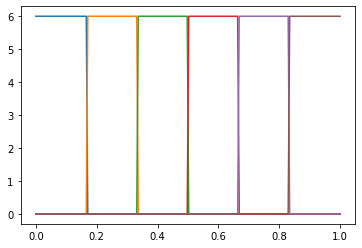

In [8]:
for i in range(m+k):
    plt.plot(xs, list(map(lambda x: Mspline(x, 1, i), xs)))

## Degree k = 2

In [9]:
k = 2
t = np.concatenate([np.repeat(a, k-1), bs, np.repeat(b, k-1)])

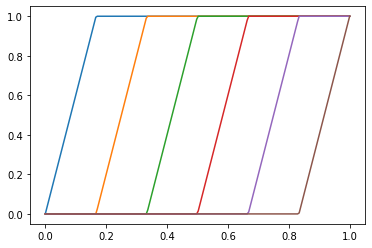

In [10]:
for i in range(m+k-1):
    plt.plot(xs, list(map(lambda x: Ispline(x, 1, i+1), xs)))

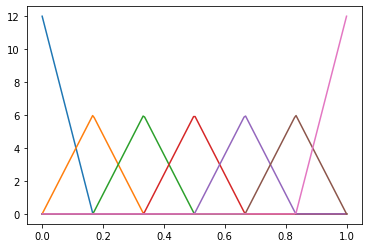

In [11]:
for i in range(m+k):
    plt.plot(xs, list(map(lambda x: Mspline(x, 2, i), xs)))

## Degree k = 3

In [12]:
k = 3
t = np.concatenate([np.repeat(a, k-1), bs, np.repeat(b, k-1)])

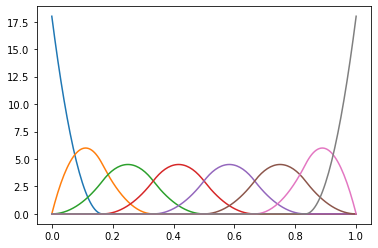

In [13]:
for i in range(m+k):
    plt.plot(xs, list(map(lambda x: Mspline(x, 3, i), xs)))

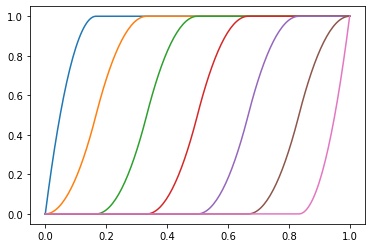

In [14]:
for i in range(m+k-1):
    plt.plot(xs, list(map(lambda x: Ispline(x, 2, i+1), xs)))

## Degree k = 4

In [15]:
k = 4
t = np.concatenate([np.repeat(a, k-1), bs, np.repeat(b, k-1)])

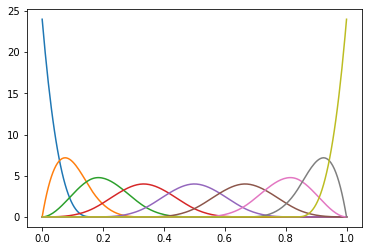

In [16]:
for i in range(m+k):
    plt.plot(xs, list(map(lambda x: Mspline(x, 4, i), xs)))

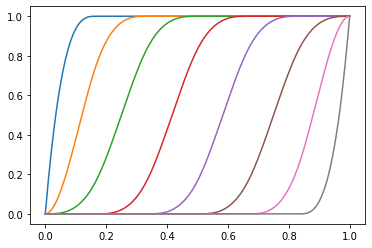

In [17]:
for i in range(m+k-1):
    plt.plot(xs, list(map(lambda x: Ispline(x, 3, i+1), xs)))

# Using CVXOPT for a non-decreasing cubic spline fit

In [18]:
# https://github.com/jihoo-kim/Coronavirus-Dataset
raw = pd.read_csv("/Users/eric/Desktop/covid19/Coronavirus-Dataset/patient.csv")
n_infected = raw.shape[0]
n_deceased = sum(pd.notna(raw['deceased_date']))
clean = raw[raw['birth_year'].notna()]
age = pd.Series(2020 - clean['birth_year'], name='age')
died = pd.Series(clean['deceased_date'].notna(), name='died').astype(float)
x = np.array(age)
y = np.array(died)
maxage = max(x)

In [19]:
m = 5 # Number of interior breakpoints
a = 0. # Min age
b = 95. # Max age
xplt = np.linspace(a, b, 100)
bs = np.linspace(a, b, m+2)
k = 4 # For order 3 I-Splines
t = np.concatenate([np.repeat(a, k-1), bs, np.repeat(b, k-1)])

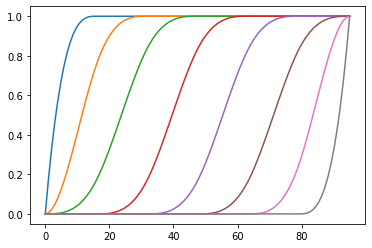

In [20]:
for i in range(m+k-1):
    plt.plot(xplt, list(map(lambda x: Ispline(x, 3, i+1), xplt)))

In [21]:
def phi(x):
    return(np.array([1.] + [Ispline(x, 3, i+1) for i in range(m+k-1)]))

In [22]:
Phi = np.vstack(list(map(phi, x)))

In [23]:
D = Phi.shape[1]

In [24]:
P = cvx.matrix(np.matmul(Phi.transpose(), Phi))
q = cvx.matrix(-np.matmul(Phi.transpose(), y))
G = cvx.matrix(np.concatenate([-np.identity(D), np.ones([1, D])], axis=0))
h = cvx.matrix(np.concatenate([np.zeros(D), np.ones(1)], axis=0))

solution = cvx.solvers.qp(P, q, G, h)

w = np.array(solution['x'])

     pcost       dcost       gap    pres   dres
 0: -4.7998e+00 -5.9546e+00  2e+01  3e+00  1e-16
 1: -4.7666e+00 -5.5647e+00  1e+00  6e-02  2e-16
 2: -4.7961e+00 -4.9064e+00  1e-01  6e-03  2e-16
 3: -4.8125e+00 -4.8261e+00  1e-02  3e-04  2e-16
 4: -4.8169e+00 -4.8182e+00  1e-03  1e-05  1e-16
 5: -4.8175e+00 -4.8176e+00  6e-05  1e-07  1e-16
 6: -4.8175e+00 -4.8175e+00  5e-06  8e-09  8e-17
 7: -4.8175e+00 -4.8175e+00  1e-06  2e-09  6e-17
Optimal solution found.


In [25]:
def fit_model(x, y):
    Phi = np.vstack(list(map(phi, x)))
    D = Phi.shape[1]
    P = cvx.matrix(np.matmul(Phi.transpose(), Phi))
    q = cvx.matrix(-np.matmul(Phi.transpose(), y))
    G = cvx.matrix(np.concatenate([-np.identity(D), np.ones([1, D])], axis=0))
    h = cvx.matrix(np.concatenate([np.zeros(D), np.ones(1)], axis=0))
    solution = cvx.solvers.qp(P, q, G, h);
    w = np.array(solution['x'])
    return w

In [54]:
def prediction(x, w):
    return(float(np.matmul(phi(x), w)))

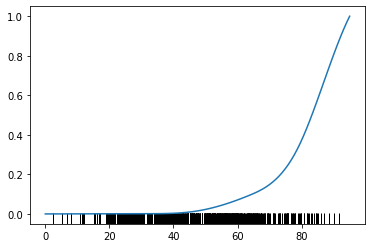

In [57]:
jittered_x = x + (2*np.random.rand(x.shape[0]) - 1)
plt.plot(xplt, list(map(lambda x: prediction(x, w), xplt)))
sns.rugplot(jittered_x, color='k')

### Generate Error Bars 

In [58]:
kde = KernelDensity(kernel='gaussian', bandwidth=5.0)
kde.fit(x.reshape((-1,1)))

KernelDensity(algorithm='auto', atol=0, bandwidth=5.0, breadth_first=True,
              kernel='gaussian', leaf_size=40, metric='euclidean',
              metric_params=None, rtol=0)

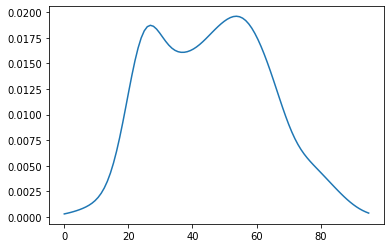

In [59]:
plt.plot(xplt, np.exp(kde.score_samples(xplt.reshape(-1,1))))

In [60]:
def gen_y(x_, w_):
    return bernoulli.rvs(prediction(x_, w_), size=1)[0]

In [61]:
# Generate error bands on the curve by simulating the generation of M=10000 new data sets and fitting the model
# to each of the new data sets.
M_num = 500
w_syn = np.zeros((M_num, len(w)))
for i in range(M_num):
    x_syn = kde.sample(n_samples=len(x)).flatten()
    y_syn = list(map(lambda v: gen_y(v, w), x_syn))
    w_hat = fit_model(x_syn, y_syn)
    w_syn[i, :] = w_hat.flatten()

     pcost       dcost       gap    pres   dres
 0: -5.5539e+00 -6.6063e+00  1e+01  3e+00  1e-16
 1: -5.5220e+00 -6.2454e+00  9e-01  6e-02  1e-16
 2: -5.5335e+00 -5.5891e+00  6e-02  3e-03  1e-16
 3: -5.5508e+00 -5.5550e+00  4e-03  9e-05  1e-16
 4: -5.5533e+00 -5.5535e+00  2e-04  2e-06  1e-16
 5: -5.5534e+00 -5.5534e+00  2e-05  2e-08  1e-16
 6: -5.5534e+00 -5.5534e+00  3e-07  1e-10  5e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.4865e+00 -7.6539e+00  2e+01  3e+00  9e-17
 1: -6.4176e+00 -7.2119e+00  1e+00  5e-02  2e-16
 2: -6.4853e+00 -6.5919e+00  1e-01  4e-03  8e-17
 3: -6.5236e+00 -6.5374e+00  1e-02  9e-17  1e-16
 4: -6.5304e+00 -6.5314e+00  1e-03  1e-16  2e-16
 5: -6.5311e+00 -6.5312e+00  8e-05  1e-16  2e-16
 6: -6.5312e+00 -6.5312e+00  2e-06  4e-16  3e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.1533e+00 -1.0348e+01  2e+01  3e+00  1e-16
 1: -9.0828e+00 -9.9305e+00  1e+00  9e-02  1e-16
 2: -9.1540e+00 -9.2767e

     pcost       dcost       gap    pres   dres
 0: -8.5275e+00 -9.6018e+00  2e+01  3e+00  1e-16
 1: -8.4805e+00 -9.1797e+00  1e+00  7e-02  1e-16
 2: -8.5022e+00 -8.5853e+00  9e-02  5e-03  2e-16
 3: -8.5134e+00 -8.5196e+00  6e-03  5e-05  9e-17
 4: -8.5155e+00 -8.5160e+00  6e-04  4e-06  9e-17
 5: -8.5157e+00 -8.5158e+00  7e-05  4e-07  1e-16
 6: -8.5158e+00 -8.5158e+00  3e-06  2e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.0011e+00 -7.1916e+00  2e+01  3e+00  1e-16
 1: -5.9157e+00 -6.7379e+00  1e+00  4e-02  2e-16
 2: -6.0107e+00 -6.1213e+00  1e-01  3e-03  2e-16
 3: -6.0640e+00 -6.0772e+00  1e-02  3e-16  2e-16
 4: -6.0725e+00 -6.0732e+00  8e-04  2e-16  1e-16
 5: -6.0729e+00 -6.0729e+00  1e-05  2e-16  1e-16
 6: -6.0729e+00 -6.0729e+00  1e-07  3e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.7045e+00 -7.8756e+00  2e+01  3e+00  3e-16
 1: -6.6596e+00 -7.4457e+00  1e+00  9e-02  1e-16
 2: -6.7106e+00 -6.8366e

     pcost       dcost       gap    pres   dres
 0: -7.2382e+00 -8.3074e+00  1e+01  3e+00  1e-16
 1: -7.2003e+00 -7.9119e+00  9e-01  6e-02  1e-16
 2: -7.2129e+00 -7.2878e+00  8e-02  4e-03  1e-16
 3: -7.2221e+00 -7.2290e+00  7e-03  3e-04  1e-16
 4: -7.2260e+00 -7.2263e+00  3e-04  4e-06  1e-16
 5: -7.2263e+00 -7.2263e+00  9e-06  4e-08  1e-16
 6: -7.2263e+00 -7.2263e+00  9e-08  4e-10  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.4734e+00 -6.6450e+00  2e+01  3e+00  1e-16
 1: -5.4328e+00 -6.2333e+00  1e+00  4e-02  1e-16
 2: -5.4805e+00 -5.5901e+00  1e-01  3e-03  1e-16
 3: -5.5034e+00 -5.5183e+00  1e-02  2e-16  1e-16
 4: -5.5077e+00 -5.5094e+00  2e-03  8e-17  2e-16
 5: -5.5085e+00 -5.5086e+00  6e-05  1e-16  9e-17
 6: -5.5086e+00 -5.5086e+00  6e-07  3e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.8602e+00 -5.9861e+00  1e+01  3e+00  1e-16
 1: -4.8417e+00 -5.6238e+00  1e+00  5e-02  1e-16
 2: -4.8593e+00 -4.9467e

     pcost       dcost       gap    pres   dres
 0: -8.4132e+00 -9.5128e+00  2e+01  3e+00  2e-16
 1: -8.3833e+00 -9.0935e+00  9e-01  5e-02  1e-16
 2: -8.4096e+00 -8.4934e+00  9e-02  4e-03  9e-17
 3: -8.4201e+00 -8.4289e+00  9e-03  2e-04  1e-16
 4: -8.4215e+00 -8.4222e+00  6e-04  9e-06  1e-16
 5: -8.4217e+00 -8.4217e+00  5e-05  9e-10  2e-16
 6: -8.4217e+00 -8.4217e+00  1e-06  6e-12  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.2741e+00 -4.4402e+00  2e+01  3e+00  2e-16
 1: -3.2377e+00 -4.0150e+00  1e+00  5e-02  1e-16
 2: -3.2861e+00 -3.4072e+00  1e-01  5e-03  9e-17
 3: -3.3082e+00 -3.3321e+00  3e-02  7e-04  1e-16
 4: -3.3126e+00 -3.3192e+00  7e-03  1e-16  1e-16
 5: -3.3150e+00 -3.3153e+00  3e-04  2e-16  1e-16
 6: -3.3151e+00 -3.3151e+00  3e-06  3e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.7567e+00 -5.9052e+00  1e+01  3e+00  9e-17
 1: -4.7412e+00 -5.5107e+00  9e-01  3e-02  1e-16
 2: -4.7646e+00 -4.8502e

     pcost       dcost       gap    pres   dres
 0: -8.8411e+00 -9.9291e+00  1e+01  3e+00  1e-16
 1: -8.8271e+00 -9.5540e+00  9e-01  4e-02  1e-16
 2: -8.8375e+00 -8.9002e+00  7e-02  2e-03  9e-17
 3: -8.8406e+00 -8.8450e+00  5e-03  1e-04  8e-17
 4: -8.8415e+00 -8.8416e+00  1e-04  1e-06  1e-16
 5: -8.8415e+00 -8.8415e+00  1e-06  1e-08  7e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.3011e+00 -5.3431e+00  1e+01  3e+00  7e-17
 1: -4.2698e+00 -4.9931e+00  8e-01  4e-02  8e-17
 2: -4.2901e+00 -4.3497e+00  6e-02  2e-03  7e-17
 3: -4.3104e+00 -4.3185e+00  8e-03  2e-04  1e-16
 4: -4.3138e+00 -4.3145e+00  7e-04  8e-17  2e-16
 5: -4.3140e+00 -4.3140e+00  3e-05  1e-16  1e-16
 6: -4.3140e+00 -4.3140e+00  3e-07  1e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.3891e+00 -4.5097e+00  1e+01  3e+00  2e-16
 1: -3.3758e+00 -4.1547e+00  1e+00  5e-02  2e-16
 2: -3.3879e+00 -3.4831e+00  1e-01  5e-03  1e-16
 3: -3.4112e+00 -3.4243e

     pcost       dcost       gap    pres   dres
 0: -5.3881e+00 -6.4753e+00  1e+01  3e+00  1e-16
 1: -5.3613e+00 -6.0875e+00  9e-01  4e-02  1e-16
 2: -5.3800e+00 -5.4409e+00  7e-02  2e-03  1e-16
 3: -5.3949e+00 -5.4000e+00  5e-03  8e-05  1e-16
 4: -5.3975e+00 -5.3977e+00  3e-04  2e-06  2e-16
 5: -5.3976e+00 -5.3977e+00  2e-05  2e-16  2e-16
 6: -5.3977e+00 -5.3977e+00  3e-07  2e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.6419e+00 -5.7469e+00  2e+01  3e+00  1e-16
 1: -4.5695e+00 -5.2957e+00  1e+00  7e-02  7e-17
 2: -4.6159e+00 -4.7013e+00  1e-01  4e-03  8e-17
 3: -4.6441e+00 -4.6550e+00  1e-02  3e-04  1e-16
 4: -4.6504e+00 -4.6508e+00  4e-04  5e-06  1e-16
 5: -4.6507e+00 -4.6507e+00  8e-06  6e-08  8e-17
 6: -4.6507e+00 -4.6507e+00  8e-08  6e-10  5e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.1360e+00 -6.2921e+00  2e+01  3e+00  2e-16
 1: -5.0938e+00 -5.8480e+00  9e-01  3e-02  9e-17
 2: -5.1485e+00 -5.2471e

     pcost       dcost       gap    pres   dres
 0: -6.3955e+00 -7.5634e+00  2e+01  3e+00  1e-16
 1: -6.3561e+00 -7.1869e+00  1e+00  7e-02  1e-16
 2: -6.3949e+00 -6.5133e+00  1e-01  7e-03  8e-17
 3: -6.4291e+00 -6.4447e+00  2e-02  6e-05  1e-16
 4: -6.4344e+00 -6.4361e+00  2e-03  2e-06  1e-16
 5: -6.4351e+00 -6.4352e+00  1e-04  1e-16  1e-16
 6: -6.4352e+00 -6.4352e+00  2e-06  1e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -8.1435e+00 -9.2771e+00  1e+01  3e+00  1e-16
 1: -8.1224e+00 -8.8526e+00  9e-01  4e-02  2e-16
 2: -8.1522e+00 -8.2342e+00  9e-02  3e-03  1e-16
 3: -8.1617e+00 -8.1718e+00  1e-02  2e-04  1e-16
 4: -8.1634e+00 -8.1643e+00  9e-04  1e-05  8e-17
 5: -8.1636e+00 -8.1637e+00  3e-05  7e-08  1e-16
 6: -8.1637e+00 -8.1637e+00  3e-07  7e-10  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.3422e+00 -5.5138e+00  2e+01  3e+00  8e-17
 1: -4.3034e+00 -5.1309e+00  1e+00  9e-02  2e-16
 2: -4.3400e+00 -4.4762e

     pcost       dcost       gap    pres   dres
 0: -1.0659e+01 -1.1771e+01  1e+01  3e+00  2e-16
 1: -1.0633e+01 -1.1321e+01  9e-01  5e-02  1e-16
 2: -1.0650e+01 -1.0701e+01  6e-02  2e-03  1e-16
 3: -1.0659e+01 -1.0666e+01  7e-03  2e-04  2e-16
 4: -1.0663e+01 -1.0663e+01  5e-04  1e-16  1e-16
 5: -1.0663e+01 -1.0663e+01  4e-05  2e-16  1e-16
 6: -1.0663e+01 -1.0663e+01  6e-06  1e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.5044e+00 -3.6262e+00  2e+01  3e+00  1e-16
 1: -2.3901e+00 -3.1949e+00  1e+00  7e-02  9e-17
 2: -2.4366e+00 -2.5400e+00  1e-01  6e-03  9e-17
 3: -2.4670e+00 -2.4778e+00  1e-02  4e-04  8e-17
 4: -2.4746e+00 -2.4752e+00  6e-04  2e-06  1e-16
 5: -2.4752e+00 -2.4752e+00  8e-06  2e-08  1e-16
 6: -2.4752e+00 -2.4752e+00  8e-08  2e-10  8e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.3110e+00 -7.4283e+00  2e+01  3e+00  2e-16
 1: -6.1929e+00 -6.9876e+00  1e+00  4e-02  2e-16
 2: -6.2662e+00 -6.3630e

     pcost       dcost       gap    pres   dres
 0: -8.4763e+00 -9.6218e+00  2e+01  3e+00  2e-16
 1: -8.4115e+00 -9.1223e+00  9e-01  4e-02  1e-16
 2: -8.4763e+00 -8.5547e+00  9e-02  2e-03  2e-16
 3: -8.5020e+00 -8.5128e+00  1e-02  3e-04  1e-16
 4: -8.5071e+00 -8.5075e+00  4e-04  1e-06  1e-16
 5: -8.5073e+00 -8.5073e+00  4e-05  1e-16  4e-16
 6: -8.5073e+00 -8.5073e+00  1e-06  3e-16  9e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.3617e+00 -7.5202e+00  2e+01  3e+00  2e-16
 1: -6.3114e+00 -7.0937e+00  1e+00  6e-02  1e-16
 2: -6.3631e+00 -6.4737e+00  1e-01  5e-03  1e-16
 3: -6.3857e+00 -6.4064e+00  2e-02  4e-04  1e-16
 4: -6.3906e+00 -6.3926e+00  2e-03  2e-16  7e-17
 5: -6.3915e+00 -6.3916e+00  7e-05  2e-16  8e-17
 6: -6.3916e+00 -6.3916e+00  7e-07  4e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.8592e+00 -6.9762e+00  1e+01  3e+00  8e-17
 1: -5.8181e+00 -6.6019e+00  1e+00  7e-02  1e-16
 2: -5.8442e+00 -5.9400e

     pcost       dcost       gap    pres   dres
 0: -4.1469e+00 -5.2136e+00  1e+01  3e+00  1e-16
 1: -4.1266e+00 -4.8452e+00  9e-01  5e-02  1e-16
 2: -4.1297e+00 -4.1958e+00  7e-02  3e-03  7e-17
 3: -4.1409e+00 -4.1485e+00  8e-03  1e-16  1e-16
 4: -4.1421e+00 -4.1426e+00  5e-04  8e-17  1e-16
 5: -4.1423e+00 -4.1423e+00  1e-05  1e-16  1e-16
 6: -4.1423e+00 -4.1423e+00  1e-07  6e-17  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -8.9946e+00 -1.0113e+01  2e+01  3e+00  2e-16
 1: -8.9124e+00 -9.6314e+00  1e+00  8e-02  2e-16
 2: -8.9585e+00 -9.0439e+00  1e-01  6e-03  9e-17
 3: -8.9856e+00 -8.9892e+00  4e-03  9e-05  8e-17
 4: -8.9878e+00 -8.9878e+00  6e-05  1e-06  2e-16
 5: -8.9878e+00 -8.9878e+00  6e-07  1e-08  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -8.8004e+00 -9.9010e+00  1e+01  3e+00  2e-16
 1: -8.7809e+00 -9.4935e+00  1e+00  7e-02  2e-16
 2: -8.7934e+00 -8.8342e+00  5e-02  2e-03  2e-16
 3: -8.8093e+00 -8.8151e

     pcost       dcost       gap    pres   dres
 0: -4.9253e+00 -6.0301e+00  1e+01  3e+00  8e-17
 1: -4.9116e+00 -5.6584e+00  9e-01  5e-02  9e-17
 2: -4.9241e+00 -5.0071e+00  9e-02  4e-03  5e-17
 3: -4.9312e+00 -4.9395e+00  9e-03  3e-04  1e-16
 4: -4.9338e+00 -4.9346e+00  7e-04  9e-17  1e-16
 5: -4.9342e+00 -4.9342e+00  8e-05  9e-17  1e-16
 6: -4.9342e+00 -4.9342e+00  9e-06  8e-17  1e-16
 7: -4.9342e+00 -4.9342e+00  3e-07  1e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.2134e+00 -6.2722e+00  2e+01  3e+00  1e-16
 1: -5.0567e+00 -5.8616e+00  1e+00  7e-02  2e-16
 2: -5.1121e+00 -5.2183e+00  1e-01  6e-03  1e-16
 3: -5.1534e+00 -5.1624e+00  9e-03  2e-04  1e-16
 4: -5.1596e+00 -5.1601e+00  5e-04  2e-06  1e-16
 5: -5.1598e+00 -5.1598e+00  5e-05  1e-16  2e-16
 6: -5.1598e+00 -5.1598e+00  6e-06  1e-16  5e-16
 7: -5.1598e+00 -5.1598e+00  8e-07  2e-16  4e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.7099e+00 -6.8663e

     pcost       dcost       gap    pres   dres
 0: -2.8864e+00 -4.0777e+00  2e+01  3e+00  1e-16
 1: -2.8327e+00 -3.6670e+00  1e+00  5e-02  1e-16
 2: -2.8941e+00 -3.0223e+00  1e-01  6e-03  1e-16
 3: -2.9385e+00 -2.9521e+00  1e-02  8e-05  1e-16
 4: -2.9409e+00 -2.9428e+00  2e-03  9e-06  8e-17
 5: -2.9420e+00 -2.9422e+00  2e-04  4e-07  9e-17
 6: -2.9422e+00 -2.9422e+00  8e-06  3e-09  1e-16
 7: -2.9422e+00 -2.9422e+00  1e-07  3e-11  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.9118e+00 -8.0498e+00  1e+01  3e+00  1e-16
 1: -6.9009e+00 -7.6693e+00  9e-01  4e-02  1e-16
 2: -6.9142e+00 -6.9864e+00  8e-02  3e-03  1e-16
 3: -6.9194e+00 -6.9240e+00  5e-03  1e-04  6e-17
 4: -6.9204e+00 -6.9205e+00  1e-04  1e-06  9e-17
 5: -6.9204e+00 -6.9204e+00  1e-06  1e-08  6e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -8.4267e+00 -9.4838e+00  2e+01  3e+00  1e-16
 1: -8.3899e+00 -9.0491e+00  9e-01  6e-02  2e-16
 2: -8.4094e+00 -8.4931e

     pcost       dcost       gap    pres   dres
 0: -5.2269e+00 -6.3817e+00  2e+01  3e+00  2e-16
 1: -5.1732e+00 -5.9592e+00  1e+00  5e-02  1e-16
 2: -5.2272e+00 -5.3362e+00  1e-01  5e-03  1e-16
 3: -5.2598e+00 -5.2748e+00  1e-02  6e-06  1e-16
 4: -5.2667e+00 -5.2683e+00  2e-03  6e-08  1e-16
 5: -5.2678e+00 -5.2679e+00  1e-04  1e-16  1e-16
 6: -5.2679e+00 -5.2679e+00  5e-06  2e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.9731e+00 -5.0838e+00  1e+01  3e+00  8e-17
 1: -3.9458e+00 -4.6831e+00  9e-01  5e-02  1e-16
 2: -3.9721e+00 -4.0606e+00  1e-01  4e-03  1e-16
 3: -3.9843e+00 -3.9992e+00  2e-02  5e-04  1e-16
 4: -3.9880e+00 -3.9894e+00  1e-03  4e-06  7e-17
 5: -3.9888e+00 -3.9889e+00  9e-05  3e-08  9e-17
 6: -3.9889e+00 -3.9889e+00  2e-06  2e-10  9e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.7355e+00 -6.8531e+00  2e+01  3e+00  8e-17
 1: -5.6906e+00 -6.4103e+00  1e+00  1e-01  2e-16
 2: -5.7214e+00 -5.8299e

     pcost       dcost       gap    pres   dres
 0: -5.6014e+00 -6.7385e+00  2e+01  3e+00  1e-16
 1: -5.5092e+00 -6.3303e+00  1e+00  1e-01  8e-17
 2: -5.5484e+00 -5.6706e+00  2e-01  1e-02  1e-16
 3: -5.5733e+00 -5.5940e+00  3e-02  1e-03  2e-16
 4: -5.5750e+00 -5.5769e+00  2e-03  2e-16  2e-16
 5: -5.5759e+00 -5.5760e+00  3e-05  1e-16  8e-17
 6: -5.5760e+00 -5.5760e+00  3e-07  1e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.7132e+00 -7.8146e+00  1e+01  3e+00  1e-16
 1: -6.6741e+00 -7.4538e+00  9e-01  4e-02  6e-17
 2: -6.7006e+00 -6.8013e+00  1e-01  4e-03  1e-16
 3: -6.7356e+00 -6.7509e+00  2e-02  3e-04  9e-17
 4: -6.7444e+00 -6.7460e+00  2e-03  1e-05  2e-16
 5: -6.7451e+00 -6.7452e+00  1e-04  6e-08  2e-16
 6: -6.7451e+00 -6.7451e+00  2e-06  5e-10  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.2905e+00 -6.4177e+00  1e+01  3e+00  1e-16
 1: -5.2706e+00 -6.0565e+00  9e-01  4e-02  1e-16
 2: -5.2870e+00 -5.3724e

     pcost       dcost       gap    pres   dres
 0: -8.8622e+00 -1.0042e+01  2e+01  3e+00  9e-17
 1: -8.8012e+00 -9.5590e+00  1e+00  4e-02  1e-16
 2: -8.8795e+00 -8.9737e+00  1e-01  3e-03  1e-16
 3: -8.9174e+00 -8.9303e+00  1e-02  1e-16  1e-16
 4: -8.9224e+00 -8.9230e+00  6e-04  2e-16  1e-16
 5: -8.9226e+00 -8.9227e+00  5e-05  2e-16  7e-17
 6: -8.9227e+00 -8.9227e+00  1e-06  8e-17  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -8.4976e+00 -9.5197e+00  1e+01  3e+00  9e-17
 1: -8.4423e+00 -9.0705e+00  8e-01  4e-02  1e-16
 2: -8.4707e+00 -8.5369e+00  7e-02  3e-03  1e-16
 3: -8.4877e+00 -8.4932e+00  5e-03  1e-05  2e-16
 4: -8.4901e+00 -8.4905e+00  4e-04  1e-06  2e-16
 5: -8.4903e+00 -8.4904e+00  3e-05  5e-09  8e-17
 6: -8.4904e+00 -8.4904e+00  2e-06  1e-11  8e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.0105e+00 -7.1783e+00  2e+01  3e+00  1e-16
 1: -5.9214e+00 -6.6922e+00  1e+00  6e-02  1e-16
 2: -6.0210e+00 -6.1259e

     pcost       dcost       gap    pres   dres
 0: -7.3471e+00 -8.5171e+00  2e+01  3e+00  9e-17
 1: -7.2759e+00 -8.0827e+00  9e-01  3e-02  1e-16
 2: -7.3446e+00 -7.4449e+00  1e-01  3e-03  6e-17
 3: -7.3866e+00 -7.3990e+00  1e-02  2e-16  7e-17
 4: -7.3910e+00 -7.3927e+00  2e-03  2e-16  1e-16
 5: -7.3920e+00 -7.3924e+00  4e-04  4e-17  1e-16
 6: -7.3921e+00 -7.3921e+00  1e-05  2e-16  1e-16
 7: -7.3921e+00 -7.3921e+00  1e-07  2e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.4214e+00 -6.5816e+00  2e+01  3e+00  3e-16
 1: -5.3847e+00 -6.1436e+00  9e-01  5e-02  1e-16
 2: -5.3873e+00 -5.4152e+00  3e-02  1e-03  1e-16
 3: -5.3930e+00 -5.3956e+00  3e-03  4e-05  2e-16
 4: -5.3947e+00 -5.3948e+00  6e-05  4e-07  2e-16
 5: -5.3948e+00 -5.3948e+00  6e-07  4e-09  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -7.8333e+00 -8.9791e+00  2e+01  3e+00  9e-17
 1: -7.7784e+00 -8.5358e+00  1e+00  5e-02  1e-16
 2: -7.8234e+00 -7.9128e

     pcost       dcost       gap    pres   dres
 0: -7.7429e+00 -8.9022e+00  2e+01  3e+00  1e-16
 1: -7.6232e+00 -8.4215e+00  1e+00  5e-02  1e-16
 2: -7.7273e+00 -7.8276e+00  1e-01  3e-03  1e-16
 3: -7.7803e+00 -7.7926e+00  1e-02  1e-04  1e-16
 4: -7.7891e+00 -7.7900e+00  9e-04  3e-06  1e-16
 5: -7.7897e+00 -7.7898e+00  9e-05  2e-16  1e-16
 6: -7.7898e+00 -7.7898e+00  5e-06  1e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.6068e+00 -7.7599e+00  2e+01  3e+00  2e-16
 1: -6.5430e+00 -7.2842e+00  9e-01  5e-02  2e-16
 2: -6.6063e+00 -6.7023e+00  1e-01  3e-03  2e-16
 3: -6.6297e+00 -6.6383e+00  9e-03  8e-05  2e-16
 4: -6.6337e+00 -6.6340e+00  3e-04  3e-07  1e-16
 5: -6.6339e+00 -6.6339e+00  3e-06  3e-09  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.0506e+00 -4.1476e+00  1e+01  3e+00  2e-16
 1: -3.0309e+00 -3.7737e+00  1e+00  6e-02  8e-17
 2: -3.0491e+00 -3.1203e+00  8e-02  4e-03  8e-17
 3: -3.0717e+00 -3.0822e

     pcost       dcost       gap    pres   dres
 0: -8.8251e+00 -9.9142e+00  2e+01  3e+00  7e-17
 1: -8.7227e+00 -9.3279e+00  1e+00  1e-01  1e-16
 2: -8.8274e+00 -8.9196e+00  1e-01  6e-03  1e-16
 3: -8.8740e+00 -8.8844e+00  1e-02  5e-05  1e-16
 4: -8.8781e+00 -8.8796e+00  2e-03  1e-16  3e-16
 5: -8.8789e+00 -8.8791e+00  2e-04  1e-16  4e-16
 6: -8.8790e+00 -8.8790e+00  2e-05  2e-16  9e-16
 7: -8.8790e+00 -8.8790e+00  3e-07  2e-16  2e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -7.1286e+00 -8.2592e+00  1e+01  3e+00  1e-16
 1: -7.1079e+00 -7.8729e+00  9e-01  4e-02  9e-17
 2: -7.1206e+00 -7.1709e+00  5e-02  1e-03  8e-17
 3: -7.1336e+00 -7.1417e+00  8e-03  1e-04  6e-17
 4: -7.1376e+00 -7.1381e+00  5e-04  8e-07  4e-17
 5: -7.1377e+00 -7.1378e+00  3e-05  7e-09  1e-16
 6: -7.1377e+00 -7.1377e+00  5e-07  6e-11  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.4029e+00 -7.5716e+00  2e+01  3e+00  1e-16
 1: -6.3608e+00 -7.1587e

     pcost       dcost       gap    pres   dres
 0: -6.1250e+00 -7.3113e+00  2e+01  3e+00  1e-16
 1: -6.0770e+00 -6.8873e+00  1e+00  7e-02  2e-16
 2: -6.1297e+00 -6.2450e+00  1e-01  6e-03  7e-17
 3: -6.1576e+00 -6.1718e+00  1e-02  2e-04  2e-16
 4: -6.1610e+00 -6.1625e+00  1e-03  2e-16  1e-16
 5: -6.1617e+00 -6.1618e+00  7e-05  3e-16  1e-16
 6: -6.1618e+00 -6.1618e+00  7e-07  1e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.2634e+00 -6.3667e+00  1e+01  3e+00  1e-16
 1: -5.2362e+00 -5.9706e+00  9e-01  5e-02  2e-16
 2: -5.2558e+00 -5.3356e+00  9e-02  3e-03  1e-16
 3: -5.2742e+00 -5.2834e+00  1e-02  3e-04  1e-16
 4: -5.2796e+00 -5.2800e+00  5e-04  8e-07  1e-16
 5: -5.2799e+00 -5.2799e+00  2e-05  1e-08  1e-16
 6: -5.2799e+00 -5.2799e+00  2e-07  1e-10  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.7719e+00 -6.8758e+00  1e+01  3e+00  1e-16
 1: -5.7342e+00 -6.4628e+00  9e-01  4e-02  1e-16
 2: -5.7625e+00 -5.8476e

     pcost       dcost       gap    pres   dres
 0: -8.1560e+00 -9.3363e+00  2e+01  3e+00  1e-16
 1: -8.0853e+00 -8.8641e+00  1e+00  6e-02  7e-17
 2: -8.1674e+00 -8.2703e+00  1e-01  4e-03  1e-16
 3: -8.2156e+00 -8.2291e+00  1e-02  3e-16  2e-16
 4: -8.2238e+00 -8.2246e+00  8e-04  1e-16  8e-17
 5: -8.2240e+00 -8.2241e+00  1e-05  1e-16  1e-16
 6: -8.2240e+00 -8.2240e+00  1e-07  1e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.9581e+00 -7.0515e+00  2e+01  3e+00  1e-16
 1: -5.7623e+00 -6.5421e+00  1e+00  6e-02  2e-16
 2: -5.8868e+00 -5.9943e+00  1e-01  4e-03  2e-16
 3: -5.9352e+00 -5.9466e+00  1e-02  1e-04  1e-16
 4: -5.9432e+00 -5.9440e+00  8e-04  9e-18  7e-17
 5: -5.9439e+00 -5.9440e+00  1e-05  2e-17  1e-16
 6: -5.9440e+00 -5.9440e+00  1e-07  5e-17  8e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.8425e+00 -6.9935e+00  2e+01  3e+00  1e-16
 1: -5.7226e+00 -6.5248e+00  1e+00  7e-02  1e-16
 2: -5.8043e+00 -5.9161e

     pcost       dcost       gap    pres   dres
 0: -7.9396e+00 -9.0059e+00  1e+01  3e+00  9e-17
 1: -7.8933e+00 -8.6219e+00  9e-01  6e-02  1e-16
 2: -7.9116e+00 -7.9840e+00  8e-02  4e-03  8e-17
 3: -7.9316e+00 -7.9394e+00  8e-03  3e-04  2e-16
 4: -7.9352e+00 -7.9355e+00  4e-04  3e-06  1e-16
 5: -7.9354e+00 -7.9354e+00  2e-05  1e-08  2e-16
 6: -7.9354e+00 -7.9354e+00  4e-07  1e-10  2e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -7.9891e+00 -9.1461e+00  2e+01  3e+00  1e-16
 1: -7.9304e+00 -8.7049e+00  1e+00  7e-02  2e-16
 2: -7.9731e+00 -8.0703e+00  1e-01  6e-03  2e-16
 3: -7.9969e+00 -8.0094e+00  1e-02  4e-04  2e-16
 4: -8.0009e+00 -8.0022e+00  1e-03  2e-16  9e-17
 5: -8.0018e+00 -8.0019e+00  9e-05  1e-16  1e-16
 6: -8.0019e+00 -8.0019e+00  1e-06  1e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.4218e+00 -6.4828e+00  1e+01  3e+00  1e-16
 1: -5.3876e+00 -6.0773e+00  9e-01  5e-02  1e-16
 2: -5.4088e+00 -5.4648e

     pcost       dcost       gap    pres   dres
 0: -6.1680e+00 -7.3300e+00  2e+01  3e+00  7e-17
 1: -6.0683e+00 -6.8468e+00  1e+00  5e-02  2e-16
 2: -6.1777e+00 -6.2884e+00  1e-01  3e-03  2e-16
 3: -6.2332e+00 -6.2471e+00  1e-02  5e-06  1e-16
 4: -6.2390e+00 -6.2407e+00  2e-03  1e-07  1e-16
 5: -6.2400e+00 -6.2402e+00  2e-04  1e-16  1e-16
 6: -6.2401e+00 -6.2402e+00  1e-05  2e-16  1e-16
 7: -6.2401e+00 -6.2401e+00  6e-07  1e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -8.0046e+00 -9.0769e+00  1e+01  3e+00  1e-16
 1: -7.9932e+00 -8.6897e+00  8e-01  4e-02  8e-17
 2: -8.0054e+00 -8.0621e+00  6e-02  2e-03  2e-16
 3: -8.0078e+00 -8.0163e+00  9e-03  3e-04  2e-16
 4: -8.0091e+00 -8.0103e+00  1e-03  2e-16  2e-16
 5: -8.0093e+00 -8.0094e+00  1e-04  2e-16  8e-17
 6: -8.0094e+00 -8.0094e+00  1e-05  2e-16  1e-16
 7: -8.0094e+00 -8.0094e+00  9e-07  2e-16  9e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.5428e+00 -7.7148e

     pcost       dcost       gap    pres   dres
 0: -6.0938e+00 -7.1991e+00  1e+01  3e+00  1e-16
 1: -6.0635e+00 -6.7899e+00  9e-01  5e-02  1e-16
 2: -6.0854e+00 -6.1714e+00  1e-01  4e-03  9e-17
 3: -6.0938e+00 -6.1021e+00  9e-03  3e-04  1e-16
 4: -6.0982e+00 -6.0987e+00  5e-04  3e-06  1e-16
 5: -6.0986e+00 -6.0986e+00  2e-05  4e-08  1e-16
 6: -6.0986e+00 -6.0986e+00  1e-06  3e-10  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -8.1374e+00 -9.1694e+00  2e+01  3e+00  3e-16
 1: -8.0309e+00 -8.6262e+00  1e+00  2e-01  2e-16
 2: -8.0264e+00 -8.1031e+00  1e-01  1e-02  2e-16
 3: -8.0512e+00 -8.0587e+00  8e-03  1e-04  1e-16
 4: -8.0528e+00 -8.0538e+00  1e-03  2e-05  1e-16
 5: -8.0535e+00 -8.0537e+00  2e-04  2e-16  4e-16
 6: -8.0536e+00 -8.0536e+00  9e-06  2e-16  3e-16
 7: -8.0536e+00 -8.0536e+00  4e-07  3e-16  2e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.7962e+00 -5.8802e+00  1e+01  3e+00  1e-16
 1: -4.7859e+00 -5.5496e

     pcost       dcost       gap    pres   dres
 0: -4.3113e+00 -5.4851e+00  2e+01  3e+00  8e-17
 1: -4.2756e+00 -5.0945e+00  1e+00  5e-02  1e-16
 2: -4.3140e+00 -4.4202e+00  1e-01  5e-03  9e-17
 3: -4.3558e+00 -4.3657e+00  1e-02  1e-05  2e-16
 4: -4.3597e+00 -4.3606e+00  8e-04  2e-07  1e-16
 5: -4.3600e+00 -4.3600e+00  2e-05  1e-09  8e-17
 6: -4.3600e+00 -4.3600e+00  2e-07  1e-11  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.0998e+00 -7.1340e+00  1e+01  3e+00  8e-17
 1: -6.0514e+00 -6.7610e+00  1e+00  9e-02  1e-16
 2: -6.0631e+00 -6.1161e+00  6e-02  4e-03  1e-16
 3: -6.0838e+00 -6.0871e+00  3e-03  4e-05  1e-16
 4: -6.0848e+00 -6.0849e+00  9e-05  7e-07  2e-16
 5: -6.0848e+00 -6.0848e+00  9e-07  7e-09  9e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.1469e+00 -6.3213e+00  2e+01  3e+00  2e-16
 1: -5.0422e+00 -5.8972e+00  1e+00  7e-02  1e-16
 2: -5.1208e+00 -5.2405e+00  1e-01  6e-03  1e-16
 3: -5.1748e+00 -5.1834e

     pcost       dcost       gap    pres   dres
 0: -7.9539e+00 -9.0555e+00  2e+01  3e+00  2e-16
 1: -7.8523e+00 -8.6012e+00  1e+00  5e-02  2e-16
 2: -7.8999e+00 -7.9885e+00  1e-01  4e-03  2e-16
 3: -7.9208e+00 -7.9301e+00  1e-02  2e-04  1e-16
 4: -7.9245e+00 -7.9249e+00  4e-04  1e-06  1e-16
 5: -7.9246e+00 -7.9246e+00  5e-06  1e-08  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.8924e+00 -6.9933e+00  2e+01  3e+00  9e-17
 1: -5.7692e+00 -6.5789e+00  1e+00  6e-02  2e-16
 2: -5.8246e+00 -5.9180e+00  1e-01  5e-03  1e-16
 3: -5.8635e+00 -5.8699e+00  7e-03  2e-04  1e-16
 4: -5.8687e+00 -5.8688e+00  9e-05  2e-06  9e-17
 5: -5.8688e+00 -5.8688e+00  9e-07  2e-08  8e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.7426e+00 -6.8103e+00  1e+01  3e+00  1e-16
 1: -5.7283e+00 -6.4640e+00  9e-01  6e-02  2e-16
 2: -5.7284e+00 -5.7653e+00  4e-02  1e-03  9e-17
 3: -5.7337e+00 -5.7380e+00  4e-03  8e-05  1e-16
 4: -5.7353e+00 -5.7355e

In [63]:
values = np.zeros((M_num, len(xplt)))

In [64]:
for i in range(M_num):
    values[i, :] = list(map(lambda v: prediction(v, w_syn[i]), xplt))

In [65]:
qs = np.vstack(list(map(lambda v: np.quantile(values[:, v], [.01, .99]), range(len(xplt)))))

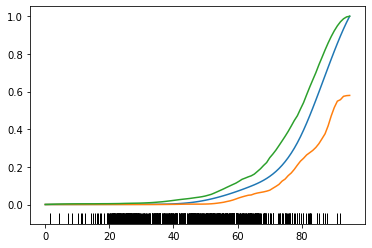

In [66]:
jittered_x = x + (2*np.random.rand(x.shape[0]) - 1)
plt.plot(xplt, list(map(lambda x: prediction(x, w), xplt)))
sns.rugplot(jittered_x, color='k')
plt.plot(xplt, qs[:, 0])
plt.plot(xplt, qs[:, 1])